In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

## Prepping Data

In [2]:
df = pd.read_csv("league_matches.csv")

In [3]:
# Dropping items as we wont use that now
x = df.drop(columns = ['items','result'], axis = 1)
y = df['result']

In [4]:
scaler = StandardScaler()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [6]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train= torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

## Creating the model

### Defining model

In [13]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden = 3):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(input_dim,1)
        

    def forward(self, x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        return x

In [14]:
input_dim = X_train.shape[1]

In [15]:
model = Model(input_dim)

In [16]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.01)

### Training model

In [17]:
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).detach()
    y_pred_test = model(X_test).detach()
    
train_accuracy = ((y_pred_train > 0.5) == y_train).float().mean()
test_accuracy = ((y_pred_test > 0.5) == y_test).float().mean()

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch [100/1000], Loss: 0.5511
Epoch [200/1000], Loss: 0.5139
Epoch [300/1000], Loss: 0.4905
Epoch [400/1000], Loss: 0.4741
Epoch [500/1000], Loss: 0.4620
Epoch [600/1000], Loss: 0.4526
Epoch [700/1000], Loss: 0.4452
Epoch [800/1000], Loss: 0.4392
Epoch [900/1000], Loss: 0.4344
Epoch [1000/1000], Loss: 0.4304
Train Accuracy: 0.8361
Test Accuracy: 0.8750


## Visualizing impact of each feature

   Feature  Importance
2  assists    0.685640
4     gold    0.420234
0    kills    0.260392
5   vision   -0.042811
3       cs   -0.317038
1   deaths   -1.148409


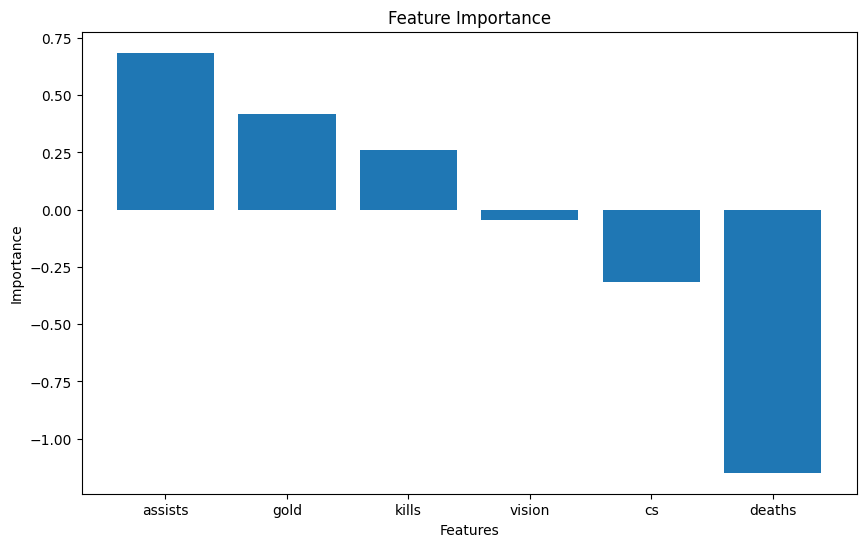

In [23]:
weights = model.linear1.weight.data.numpy().flatten()
features = x.columns

feature_importance = pd.DataFrame({'Feature': features, 'Importance': weights})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()